# Topic Modelling and Attitudes from Twitter Data

A short tutorial by **Eduardo Graells-Garrido** / <egraells@dcc.uchile.cl> / [@ZorzalErrante](http://twitter.com/ZorzalErrante) / http://datagramas.cl 

Last updated: **7/7/2022**

Repository link: **https://github.com/zorzalerrante/tsundoku/**

There go to **notebooks/bigsss_topic_model_workshop.ipynb**

Today we have two aims:

1. Identify **narratives** in Twitter discussion with a given context (geographical in this example). We will use topic modelling for this.
2. Identify sentiment/emotions in the discussion. We will use transformers (a deep learning architecture) for this.

## Preamble

This notebook requires the [tsundoku environment](https://github.com/zorzalerrante/tsundoku). Clone the repository and execute the following:

```
# Create conda environment, install dependencies on it and activate it
conda create --name tsundoku --file environment.yml
conda activate tsundoku

python -m ipykernel install --user --name tsundoku --display-name "Python (tsundoku)"
```

### Google Colab

If you use Google Colab you need to install the dependencies in the server. This will take a few minutes! You need to execute the first cell, wait until the server gives you a restart error, and then run the second cell.

*Note that you may need a GPU environment*. I'm not sure why this happens, with a CPU-only environment sometimes hangs when installing `condacolab`. Also note that **most of the times there is a problem with some dependencies** :( 

In [8]:
try:
    import google.colab
    !pip uninstall matplotlib -y
    !pip install -q condacolab
    
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

In [9]:
try:
    import google.colab
    !git clone https://github.com/zorzalerrante/tsundoku.git tsundoku_git
    !mamba env update --name base --file tsundoku_git/environment-colab.yml
    !pip install -e tsundoku_git/
    !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
    #!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
    !pip install transformers
except ModuleNotFoundError:
    pass

### Python

Here we load all the dependencies we will use in the notebook.

In [10]:
import csv
import urllib.request

import dask.dataframe as dd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from aves.features.geo import clip_area_geodataframe, to_point_geodataframe
from aves.features.sparse import sparse_matrix_to_long_dataframe
from aves.features.utils import normalize_rows, standardize_columns
from aves.visualization.figures import small_multiples_from_geodataframe
from aves.visualization.maps import choropleth_map
from aves.visualization.text import draw_wordcloud
from scipy.special import softmax
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from tsundoku.features.dtm import build_vocabulary, tokens_to_document_term_matrix
from tsundoku.features.text import tokenize


## Dataset

This is a small dataset of tweets about migration in UK. See https://fcorowe.github.io/intro-gds/04-spatial_econometrics.html for a description.

**Note**: You may need to update the path to the file.

In [11]:
tweets = dd.read_csv('../../gds-bigsss-groningen/data/toy-data/uk_geo_tweets_01012019_31012019.csv')
tweets.head()

,tweet_id,created_at,author_id,place_id,place_name,full_place_name,lat,long,exact_coords,bbox,...,source,conversation_id,reply_settings,referenced_tweets_type,referenced_tweets_id,in_reply_to_user_id,annotations,mentions,linked_url,possibly_sensitive
0,1080251664802689025,2019-01-01 23:57:21+00:00,246459126,544762ebf7fda780,Islington,"Islington, London",-0.109181,51.546926,False,-0.1420579 51.5185518 -0.076305 51.575301,...,Twitter for Android,1080230760328646656,everyone,replied_to,1080251100882706433,1023298063086092291,,"[{'start': 0, 'end': 13, 'username': 'ArronDav...",,False
1,1080243355680948224,2019-01-01 23:24:20+00:00,1934557914,40b868fc3fcc305f,Haslingden,"Haslingden, England",-2.325504,53.694893,False,-2.344475 53.6728736 -2.3065324 53.716913,...,Twitter for iPhone,1079920220410654720,everyone,replied_to,1080241244486414336,1660080602,,"[{'start': 28, 'end': 36, 'username': 'rleskew...",,False
2,1080238132811976704,2019-01-01 23:03:35+00:00,460397753,0af014accd6f6e99,Scotland,"Scotland, United Kingdom",-4.200441,57.739454,False,-7.66085699743185 54.6336309570711 -0.74002500...,...,Twitter for Android,1080236254954958848,everyone,replied_to,1080236254954958848,20000725,"[{'start': 35, 'end': 40, 'probability': 0.688...","[{'start': 0, 'end': 13, 'username': 'jessphil...",,False
3,1080237883133517825,2019-01-01 23:02:35+00:00,20471144,44225138caa10f19,Loughborough,"Loughborough, England",-1.223952,52.766709,False,-1.2585643 52.7435249 -1.18934 52.7898929,...,Twitter for iPhone,1078263811600191488,everyone,replied_to,1080163143396048898,863628714,,"[{'start': 0, 'end': 9, 'username': 'u2rshite'...",,False
4,1080230833473105921,2019-01-01 22:34:35+00:00,1024602584,00a55bd9768a7f5c,West End,"West End, England",-1.335718,50.927791,False,-1.357977 50.908516 -1.313459 50.9470653,...,Twitter for Android,1080227910387154945,everyone,replied_to,1080227910387154945,60886384,"[{'start': 52, 'end': 55, 'probability': 0.579...","[{'start': 0, 'end': 14, 'username': 'Kevin_Ma...",,False


In [12]:
len(tweets)

3919

In [13]:
tweets.columns

Index(['tweet_id', 'created_at', 'author_id', 'place_id', 'place_name',
       'full_place_name', 'lat', 'long', 'exact_coords', 'bbox', 'place_type',
       'country_code', 'country', 'lang', 'retweet_count', 'reply_count',
       'like_count', 'quote_count', 'text', 'username', 'user_name',
       'followers_count', 'following_count', 'tweet_count', 'listed_count',
       'user_url', 'user_loc', 'user_desc', 'source', 'conversation_id',
       'reply_settings', 'referenced_tweets_type', 'referenced_tweets_id',
       'in_reply_to_user_id', 'annotations', 'mentions', 'linked_url',
       'possibly_sensitive'],
      dtype='object')

In [14]:
tweets = tweets.compute()

In [15]:
tweets['token'] = tweets['text'].apply(tokenize)

In [16]:
tweets['token'].sample(5).values[0]

['@johnsilver_1715',
 'copyyvette',
 "cooper's",
 'moderate',
 'voting',
 'record',
 'voted',
 'for',
 'iraq',
 'war',
 'voted',
 'against',
 'investigation',
 'into',
 'iraq',
 'war',
 'voted',
 'for',
 'military',
 'action',
 'in',
 'libya',
 'voted',
 'for',
 'trident',
 'abstained',
 'on',
 'tory',
 'welfare',
 'bill',
 'abstained',
 'on',
 'theresa',
 "may's",
 'immigration',
 'bill',
 'approved',
 'harsher',
 'esa',
 'tests',
 'for',
 'the',
 'disabled']

In [17]:
len(tweets)

3919

In [18]:
len(tweets['author_id'].unique())

2430

In [19]:
print('\n---\n'.join(tweets['text'].sample(10)))

We’re looking forward to this as part of our Refugee Week activities! @CounterArts @RefugeeWeek https://t.co/Q0JDOTqT0J
---
Just watched @SpeakerPelosi and @SenSchumer. They looked so insincere and wooden while trying to blame @POTUS  fot their bloody minded intrandegence. They are the ones making government workers suffer. What is wrong with controlled migration &amp; security measures?
---
@dirktherabbit If there had been strong pro immigration arguments developed 10 years ago that could cut through, rather than it being seen as an embarrassing topic, we might not be where we are today.
---
@uk_domain_names @ObiWokKanobe The new immigration policy is depressing on so many levels.

Terms for even those who do meet the salary threshold are so unappealing (temporary visa, no rights to bring families, reduced access to the services your taxes pay for) that the brightest &amp; the best won't come anymore.
---
@stephenkb @AdolphusSpriggs Yes. This tonight is much worse. They got so high an

### Dates

In [20]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

<AxesSubplot:xlabel='created_at'>

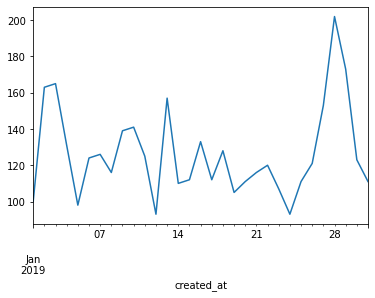

In [21]:
tweets.resample('1d', on='created_at').size().plot()

### Words

In [22]:
vocab = build_vocabulary(tweets, 'token')
vocab

,token,frequency
0,the,5093
1,to,3372
2,and,2514
3,a,2375
4,of,2351
...,...,...
16581,millisle,1
16582,parking,1
16583,millionth,1
16584,parkland,1


<AxesSubplot:ylabel='Frequency'>

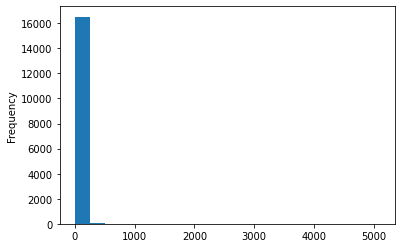

In [23]:
vocab['frequency'].plot(kind='hist', bins=20)

<AxesSubplot:ylabel='Frequency'>

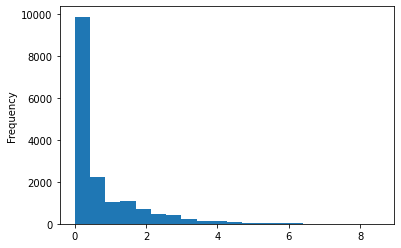

In [24]:
np.log(vocab['frequency']).plot(kind='hist', bins=20)

In [25]:
filtered_vocab = vocab[
    vocab["frequency"].between(5, vocab["frequency"].quantile(0.985))
].reset_index(drop=True)
filtered_vocab


,token,frequency
0,year,60
1,benefits,60
2,english,60
3,remain,60
4,1,60
...,...,...
2536,speaker,5
2537,jews,5
2538,@davesmi98608405,5
2539,@irisheurophile,5


In [26]:
filtered_vocab.sort_values('frequency', ascending=False).head(25)

,token,frequency
0,year,60
4,1,60
5,seeker,60
1,benefits,60
3,remain,60
2,english,60
6,look,59
7,ever,59
8,point,59
9,economy,59


### Geographical Context

In [27]:
tweets['place_name'].unique().shape

(839,)

<AxesSubplot:>

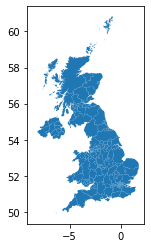

In [28]:
# https://www.geoboundaries.org/index.html#getdata
gdf = gpd.read_file('https://raw.githubusercontent.com/wmgeolab/geoBoundaries/793caebea9ccb4bb1c4f38e80684c1166daf288a/releaseData/gbOpen/GBR/ADM2/geoBoundaries-GBR-ADM2-all.zip')
gdf['geometry'] = gdf.simplify(0.0001)
gdf.plot()

In [29]:
gdf.shape

(216, 6)

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

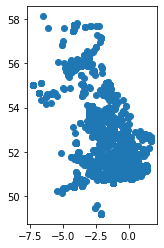

In [30]:
# somehow lat and lon are reversed in the original data.

tweets = to_point_geodataframe(tweets, 'lat', 'long', drop=True)
tweets.plot()

<AxesSubplot:>

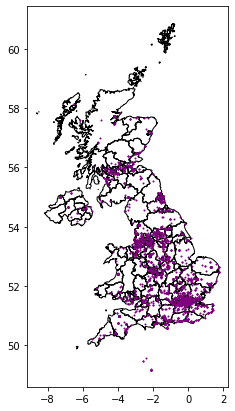

In [31]:
ax = gdf.plot(facecolor='none', edgecolor='black', figsize=(7, 7))
tweets.plot(ax=ax, color='purple', markersize=1)

In [32]:
tweets = gpd.sjoin(tweets, gdf, op='within')
print(len(tweets))
tweets.head()

3901


/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,tweet_id,created_at,author_id,place_id,place_name,full_place_name,exact_coords,bbox,place_type,country_code,...,linked_url,possibly_sensitive,token,geometry,index_right,shapeName,Level,shapeID,shapeGroup,shapeType
0,1080251664802689025,2019-01-01 23:57:21+00:00,246459126,544762ebf7fda780,Islington,"Islington, London",False,-0.1420579 51.5185518 -0.076305 51.575301,city,GB,...,,False,"[@arrondavid12, @anitabellows12, @swottyler, @...",POINT (-0.10918 51.54693),110,Islington,ADM2,GBR-ADM2-9080712B23853987,GBR,ADM2
79,1080035317665677312,2019-01-01 09:37:40+00:00,1052521027,544762ebf7fda780,Islington,"Islington, London",False,-0.1420579 51.5185518 -0.076305 51.575301,city,GB,...,,False,"[@thattimwalker, @bbcnews, there, is, no, migr...",POINT (-0.10918 51.54693),110,Islington,ADM2,GBR-ADM2-9080712B23853987,GBR,ADM2
176,1080521462199537664,2019-01-02 17:49:26+00:00,919890998959976450,544762ebf7fda780,Islington,"Islington, London",False,-0.1420579 51.5185518 -0.076305 51.575301,city,GB,...,,False,"[founded, an, award, winning, pro-bono, projec...",POINT (-0.10918 51.54693),110,Islington,ADM2,GBR-ADM2-9080712B23853987,GBR,ADM2
264,1080973461454049281,2019-01-03 23:45:31+00:00,704762496016654336,544762ebf7fda780,Islington,"Islington, London",False,-0.1420579 51.5185518 -0.076305 51.575301,city,GB,...,,False,"[@wegesusanne, @theasylum5, @realdonaldtrump, ...",POINT (-0.10918 51.54693),110,Islington,ADM2,GBR-ADM2-9080712B23853987,GBR,ADM2
309,1080895241291468801,2019-01-03 18:34:42+00:00,612544899,544762ebf7fda780,Islington,"Islington, London",False,-0.1420579 51.5185518 -0.076305 51.575301,city,GB,...,,False,"[@bechhof, couldn’t, a, high, skilled, migrant...",POINT (-0.10918 51.54693),110,Islington,ADM2,GBR-ADM2-9080712B23853987,GBR,ADM2


*Potential bug!* How do you know that all tweets are within your geography? If not, the index will have gaps. It would be better to reset it.

In [33]:
tweets = tweets.reset_index(drop=True)

In [34]:
location_counts = (
    tweets.groupby("shapeName")
    .size()
    .sort_values(ascending=False)
    .rename("n_tweets")
)

location_counts.head()

shapeName
Southwark               129
Westminster             108
Cambridgeshire           88
Lancashire               78
Kingston upon Thames     78
Name: n_tweets, dtype: int64

<AxesSubplot:>

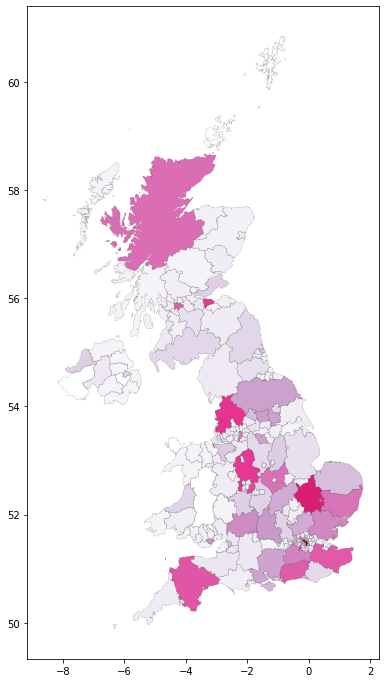

In [35]:
ax = gdf.join(location_counts, on="shapeName", how="inner").plot(
    column="n_tweets", cmap="PuRd", edgecolor="none", figsize=(12, 12)
)
gdf.plot(facecolor="none", edgecolor="black", linewidth=0.1, ax=ax)


## Narratives

### Main Representation: Document-Term Matrix

In [36]:
dtm = tokens_to_document_term_matrix(tweets, 'tweet_id', 'token', filtered_vocab['token'])
dtm

<3901x2541 sparse matrix of type '<class 'numpy.int64'>'
	with 33291 stored elements in Compressed Sparse Row format>

We observed that the most frequent words are not necessarily the most informative. We filtered out some of them, but that only diminishes the problem.

One way of improving the situation is to assign a weight to each word.

The most common weighting formula is TF-IDF.

In [37]:
tfidf = TfidfTransformer()

dtm_weighted = tfidf.fit_transform(dtm)
dtm_weighted

<3901x2541 sparse matrix of type '<class 'numpy.float64'>'
	with 33291 stored elements in Compressed Sparse Row format>

In [38]:
word_importances = sparse_matrix_to_long_dataframe(dtm_weighted, var_map=filtered_vocab['token'].to_dict())
word_importances

,index,column,value
0,12,year,0.194392
1,92,year,0.276628
2,98,year,0.212427
3,136,year,0.234096
4,268,year,0.230491
...,...,...,...
33286,2595,@irisheurophile,0.196370
33287,761,pissed,0.461081
33288,1424,pissed,0.400095
33289,3531,pissed,0.700363


In [39]:
global_word_importance = (
    word_importances.groupby("column")["value"]
    .sum()
    .sort_values(ascending=False)
)
global_word_importance.head(25)


column
prioritise      21.690663
train           19.499190
prioritises     18.627493
seeker          18.216361
abroad          18.164697
#immigration    17.931048
polling         17.012169
needs           16.609495
voting          16.607222
trafficking     16.598315
worse           16.563463
english         16.317661
oh              16.315304
cc              16.185959
anti            16.083260
@lbc            15.999266
1               15.904892
end             15.811829
refugees        15.774962
let             15.756292
remain          15.737472
i'm             15.525567
agree           15.485241
year            15.241583
look            15.232203
Name: value, dtype: float64

In [40]:
place_tweet_idx = (
    tweets.groupby("shapeName")
    .apply(lambda x: x.index.values)
    #.loc[location_counts.index]
)

place_tweet_idx

shapeName
Aberdeen City              [1321, 1322, 1323, 1324, 1325, 1326, 1327, 132...
Aberdeenshire                                       [3123, 3124, 3125, 3126]
Angus                       [3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144]
Antrim and Newtownabbey                                               [3885]
Ards and North Down                                       [3695, 3696, 3697]
                                                 ...                        
Wokingham                               [3698, 3699, 3700, 3701, 3702, 3703]
Wolverhampton                     [1588, 1589, 1590, 1591, 1592, 1593, 1594]
Worcestershire             [3408, 3409, 3410, 3411, 3412, 3413, 3414, 341...
Wrexham                    [3810, 3811, 3812, 3813, 3814, 3815, 3816, 381...
York                       [2332, 2333, 2334, 2335, 2336, 2337, 2338, 233...
Length: 204, dtype: object

In [41]:
place_dtm = np.vstack(place_tweet_idx.map(lambda x: np.squeeze(np.array(dtm[x].sum(axis=0)))))
place_dtm.shape


(204, 2541)

In [42]:
place_dtm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [43]:
place_words = pd.DataFrame(
    tfidf.transform(place_dtm).todense(),
    index=place_tweet_idx.index,
    columns=filtered_vocab["token"],
)

place_words

token,year,benefits,english,remain,1,seeker,look,ever,point,economy,...,size,jew,currency,60s,sky,speaker,jews,@davesmi98608405,@irisheurophile,pissed
shapeName,,,,,,,,,,,,,,,,,,,,,
Aberdeen City,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aberdeenshire,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angus,0.0,0.000000,0.0,0.000000,0.0,0.222339,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Antrim and Newtownabbey,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ards and North Down,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wokingham,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wolverhampton,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Worcestershire,0.0,0.151660,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
place_words.T.apply(lambda x: x.sort_values(ascending=False).head(10).index).T


,0,1,2,3,4,5,6,7,8,9
shapeName,,,,,,,,,,
Aberdeen City,assuming,scottish,cc,polling,you’re,abroad,options,mistake,repeatedly,volunteer
Aberdeenshire,christian,skills,exploring,leading,rubbish,joke,absolute,nonsense,6,running
Angus,liar,scottish,controls,seeker,ready,macron,k,indy,🏴󠁧󠁢󠁳󠁣󠁴󠁿,mugs
Antrim and Newtownabbey,journalist,fellow,balance,interest,nice,allowed,seems,manchester,special,talent
Ards and North Down,driver,gonna,special,wont,stuff,per,gets,ones,red,society
...,...,...,...,...,...,...,...,...,...,...
Wokingham,@uklabour,part,banker,budget,steel,abstention,shambles,mark,#stopbrexit,nearly
Wolverhampton,heart,means,cta,teacher,uk's,budget,picture,freedoms,speakers,payments
Worcestershire,managed,transitional,natural,protection,build,😂,benefits,@alyssa_milano,caravan,helps


## Topic Model: Non-Negative Matrix Factorization

[NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) is based on the decomposition of the document-term matrix into the multiplication of two matrices with rank $k$ (the number of topics): one with the association between documents and topics, and one with topics and terms from the vocabulary. The model is fitted by finding a local optimum to the minimization of matrix reconstruction error.

In [45]:
nmf_model = NMF(n_components=8, random_state=42)
nmf_document_topic = nmf_model.fit_transform(dtm_weighted)

In [46]:
nmf_term_topic = nmf_model.components_
nmf_term_topic.shape

(8, 2541)

In [47]:
nmf_term_topic = pd.DataFrame(nmf_term_topic.T, index=filtered_vocab['token']).pipe(normalize_rows)
nmf_term_topic

,0,1,2,3,4,5,6,7
token,,,,,,,,
year,0.000000,0.015535,0.00000,0.933175,0.051289,0.0,0.000000,0.000000
benefits,0.000000,0.000000,0.00000,1.000000,0.000000,0.0,0.000000,0.000000
english,0.000000,0.000000,0.00000,0.880845,0.000000,0.0,0.119155,0.000000
remain,0.328892,0.003983,0.18908,0.438313,0.020141,0.0,0.019592,0.000000
1,0.000000,0.033915,0.00000,0.774045,0.044403,0.0,0.000000,0.147638
...,...,...,...,...,...,...,...,...
speaker,0.221503,0.000000,0.00000,0.475625,0.000000,0.0,0.132842,0.170030
jews,0.000000,0.000000,0.00000,0.822340,0.000000,0.0,0.177660,0.000000
@davesmi98608405,0.000000,0.000000,0.00000,1.000000,0.000000,0.0,0.000000,0.000000


/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 127988 (\N{WAVING BLACK FLAG}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 917607 (\N{TAG LATIN SMALL LETTER G}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 917602 (\N{TAG LATIN SMALL LETTER B}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 917619 (\N{TAG LATIN SMALL LETTER S}) missing from current font.
  fig.canvas.draw()
/home/egraells/minic

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127988 (\N{WAVING BLACK FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 917607 (\N{TAG LATIN SMALL LETTER G}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 917602 (\N{TAG LATIN SMALL LETTER B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 917619 (\N{TAG LATIN SMALL LETTER S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: Use

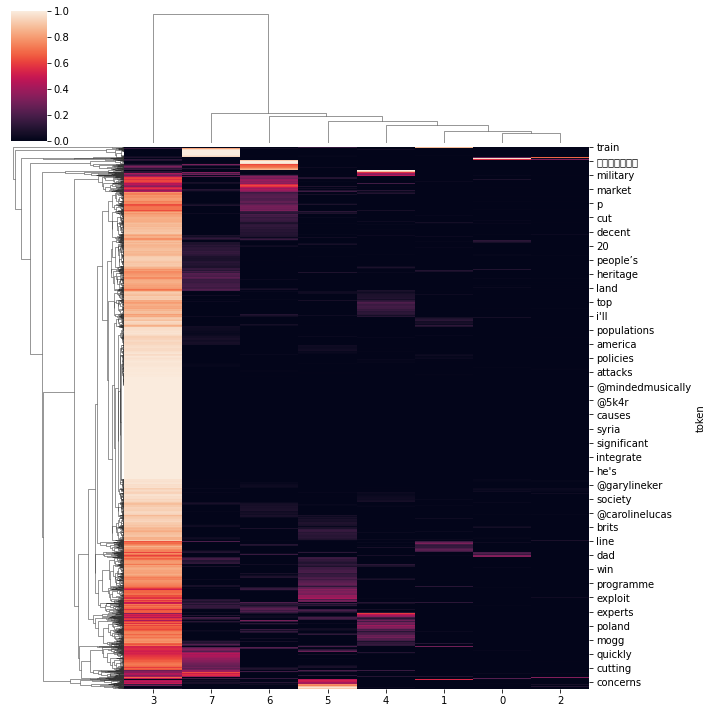

In [48]:
sns.clustermap(nmf_term_topic)

In [49]:
nmf_term_topic.apply(lambda x: x.sort_values(ascending=False).head(25).index).add_prefix('topic_')

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,yougov,staffing,trained,pissed,priorities,#immigrationbill,fm,@spazjukreattiv
1,cc,train,prioritise,floodgates,petition,monday’s,male,eritrea
2,polling,provided,uk's,economically,add,debate,independence,stars
3,abroad,commit,design,camp,signed,#nhs,confident,trio
4,prioritised,funding,released,syria,name,everything,backing,valletta
5,docs,prioritises,allow,found,calling,#austerity,#indyref2,celebratory
6,whether,shortages,docs,farage,i've,govt’s,broken,pizza
7,released,amendment,weren’t,primary,compact,#police,indy,separated
8,listen,driver,listen,claimants,goes,speaking,scottish,perform
9,review,mainly,donate,erg,pact,plans,racism,malta


In [50]:
nmf_place_topic = nmf_model.transform(tfidf.transform(place_dtm))
nmf_place_topic = (
    pd.DataFrame(nmf_place_topic, index=place_tweet_idx.index)
    .add_prefix("topic_")
    .pipe(normalize_rows)
)
nmf_place_topic


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
shapeName,,,,,,,,
Aberdeen City,0.447826,0.000000,0.072623,0.287551,0.000000,0.000000,0.169290,0.022711
Aberdeenshire,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Angus,0.000000,0.000000,0.000000,0.115043,0.000000,0.000000,0.884957,0.000000
Antrim and Newtownabbey,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Ards and North Down,0.000000,0.000000,0.000000,0.568145,0.000000,0.431855,0.000000,0.000000
...,...,...,...,...,...,...,...,...
Wokingham,0.000000,0.000000,0.000000,0.915239,0.022513,0.000000,0.062248,0.000000
Wolverhampton,0.000000,0.000000,0.011958,0.683000,0.004866,0.000000,0.267770,0.032406
Worcestershire,0.141652,0.000000,0.201694,0.542342,0.076978,0.000000,0.000000,0.037334


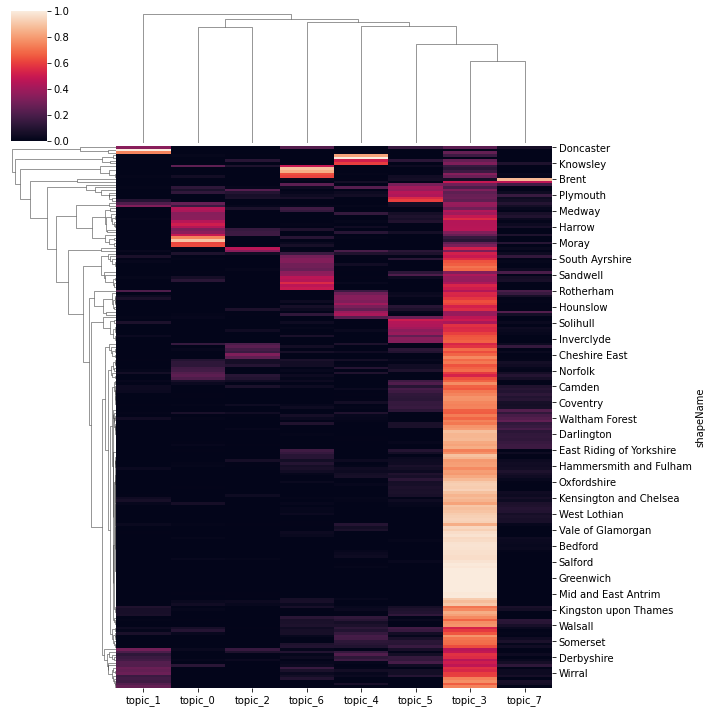

In [51]:
sns.clustermap(nmf_place_topic, metric='cosine')

In [52]:
nmf_topic_labels = nmf_term_topic.apply(lambda x: '\n'.join(x.sort_values(ascending=False).head(15).index))
nmf_topic_labels

0    yougov\ncc\npolling\nabroad\nprioritised\ndocs...
1    staffing\ntrain\nprovided\ncommit\nfunding\npr...
2    trained\nprioritise\nuk's\ndesign\nreleased\na...
3    pissed\nfloodgates\neconomically\ncamp\nsyria\...
4    priorities\npetition\nadd\nsigned\nname\ncalli...
5    #immigrationbill\nmonday’s\ndebate\n#nhs\never...
6    fm\nmale\nindependence\nconfident\nbacking\n#i...
7    @spazjukreattiv\neritrea\nstars\ntrio\nvallett...
dtype: object

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 127988 (\N{WAVING BLACK FLAG}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 917607 (\N{TAG LATIN SMALL LETTER G}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 917602 (\N{TAG LATIN SMALL LETTER B}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 917619 (\N{TAG LATIN SMALL LETTER S}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 917603 (\N{TAG LATIN SMALL LETTER C}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/pyt

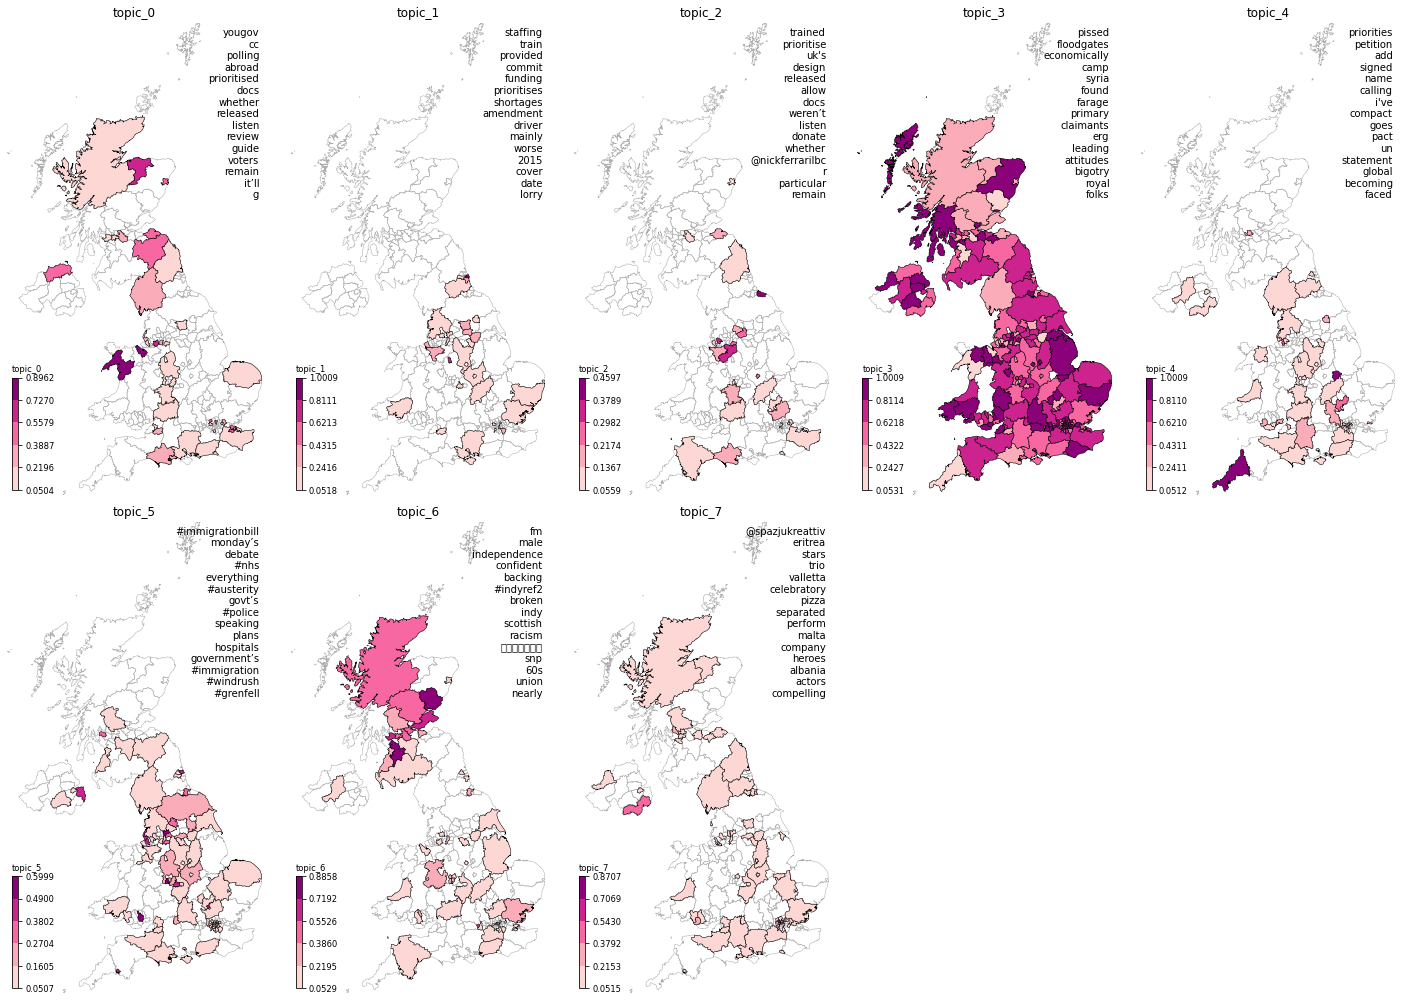

In [53]:
fig, axes = small_multiples_from_geodataframe(gdf, n_variables=len(nmf_place_topic.columns), height=7, col_wrap=5)

place_topic = nmf_place_topic
topic_labels = nmf_topic_labels

joint_gdf = gdf.join(place_topic, on='shapeName')

for ax, col, labels in zip(axes, place_topic.columns, topic_labels.values):
    gdf.plot(facecolor='none', edgecolor='#abacab', linewidth=0.5, ax=ax, aspect=None)
    
    choropleth_map(ax, joint_gdf[joint_gdf[col] >= 0.05], col, edgecolor='black', linewidth=0.5, k=5, edgebinning="fisher_jenks", palette='RdPu',
        cbar_args=dict(
            label=f"{col}",
            height="25%",
            width="3%",
            orientation="vertical",
            location="lower left",
            label_size="small",
            bbox_to_anchor=(0.0, 0.0, 0.8, 0.95),
        ),)
    ax.set_title(col)

    ax.annotate(labels, (0.99, 0.99), xycoords='axes fraction', ha='right', va='top', fontsize='medium')


fig.tight_layout()


### Latent Dirichlet Allocation (LDA)

[LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is based on a generative model based on how documents are structured: a document has topics, and topics has words, thus, a document is created by adding words to it from the topics that the document is about. It assumes that words and topics follow a Dirichlet distribution (hence the name). The model is fitted by finding the distribution parameters using Gibbs sampling or similar methods.

In [54]:
lda_model = LatentDirichletAllocation(n_components=8, random_state=42)
lda_document_topic = lda_model.fit_transform(dtm)
lda_term_topic = pd.DataFrame(lda_model.components_.T, index=filtered_vocab['token'])
lda_term_topic.apply(lambda x: x.sort_values(ascending=False).head(25).index)

,0,1,2,3,4,5,6,7
0,hate,isn't,😡,debate,abroad,france,voting,least
1,—,read,needs,status,polling,1,racism,customs
2,call,looking,that's,prioritise,cc,safe,european,saying
3,poor,office,war,change,yougov,seeker,union,important
4,calling,train,life,number,case,3,future,single
5,full,different,🙄,#nhs,😂,@lbc,someone,hard
6,@uklabour,thank,i'm,already,remain,funding,young,market
7,@jeremycorbyn,part,iraq,fact,prioritised,coming,party,believe
8,mind,left,s,reason,–,worse,bad,keep
9,next,point,@davidmetroland,doesn’t,having,mp,scottish,you’re


In [55]:
lda_place_topic = lda_model.transform(place_dtm)
lda_place_topic = pd.DataFrame(lda_place_topic, index=place_tweet_idx.index).add_prefix('topic_')
lda_place_topic

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
shapeName,,,,,,,,
Aberdeen City,0.037885,0.001391,0.001393,0.083147,0.320840,0.342061,0.110735,0.102549
Aberdeenshire,0.466527,0.273488,0.003913,0.003912,0.003912,0.003917,0.003910,0.240421
Angus,0.089949,0.136302,0.037974,0.002728,0.160734,0.002724,0.492913,0.076677
Antrim and Newtownabbey,0.015632,0.015650,0.015638,0.015645,0.015665,0.890502,0.015638,0.015631
Ards and North Down,0.008936,0.008947,0.008957,0.008942,0.477568,0.008933,0.008945,0.468772
...,...,...,...,...,...,...,...,...
Wokingham,0.170338,0.468932,0.002782,0.256121,0.002780,0.002782,0.093483,0.002782
Wolverhampton,0.071441,0.142548,0.115181,0.113424,0.147436,0.072449,0.054381,0.283141
Worcestershire,0.163242,0.000663,0.000662,0.160034,0.262701,0.192796,0.073469,0.146432


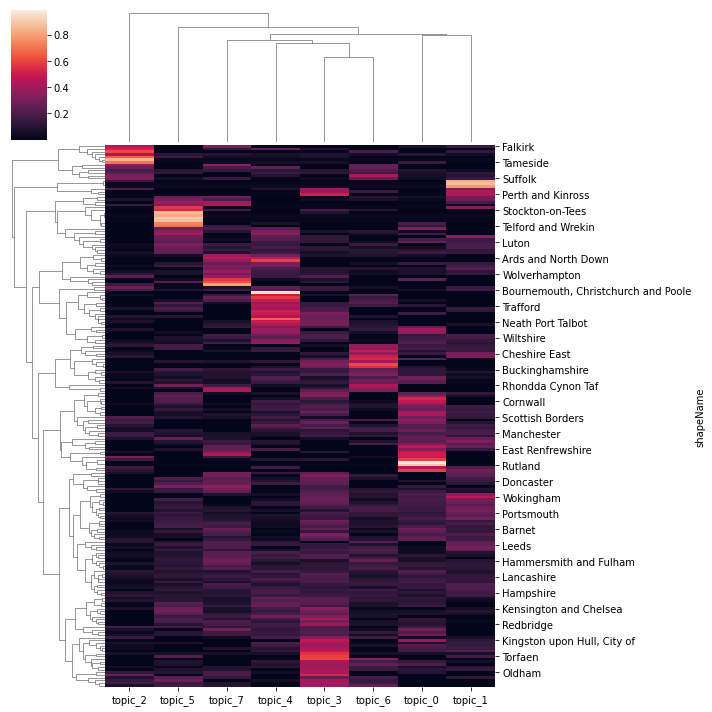

In [56]:
sns.clustermap(lda_place_topic, metric='cosine')

In [57]:
lda_topic_labels = lda_term_topic.apply(lambda x: '\n'.join(x.sort_values(ascending=False).head(15).index))
lda_topic_labels


0    hate\n—\ncall\npoor\ncalling\nfull\n@uklabour\...
1    isn't\nread\nlooking\noffice\ntrain\ndifferent...
2    😡\nneeds\nthat's\nwar\nlife\n🙄\ni'm\niraq\ns\n...
3    debate\nstatus\nprioritise\nchange\nnumber\n#n...
4    abroad\npolling\ncc\nyougov\ncase\n😂\nremain\n...
5    france\n1\nsafe\nseeker\n3\n@lbc\nfunding\ncom...
6    voting\nracism\neuropean\nunion\nfuture\nsomeo...
7    least\ncustoms\nsaying\nimportant\nsingle\nhar...
dtype: object

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/geopandas/plotting.py:470: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  plt.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python

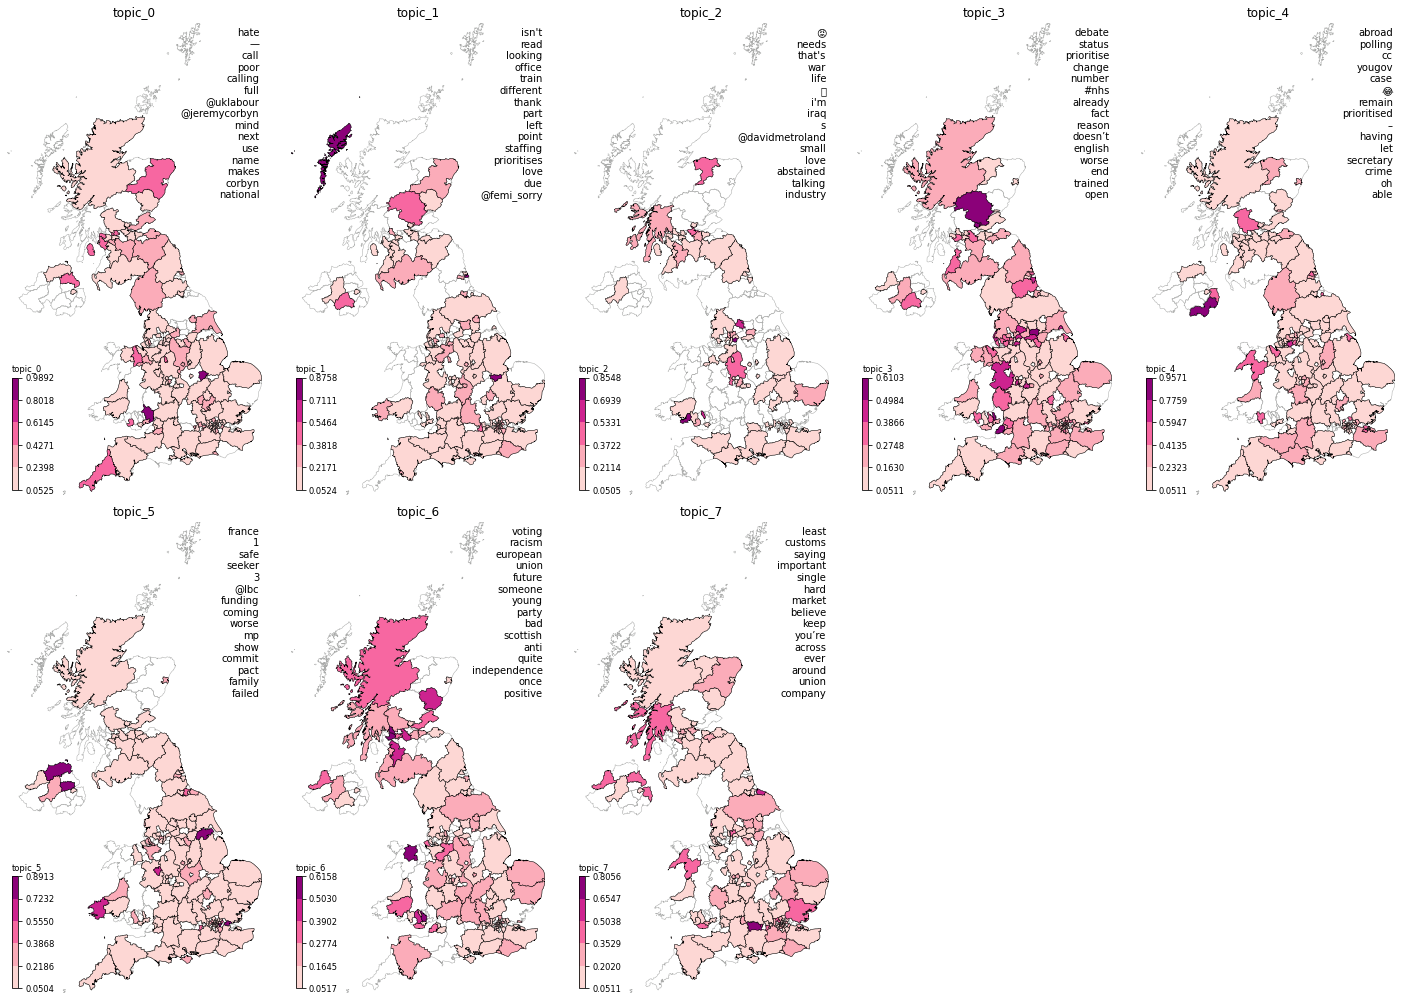

In [58]:
fig, axes = small_multiples_from_geodataframe(gdf, n_variables=len(lda_place_topic.columns), height=7, col_wrap=5)

place_topic = lda_place_topic
topic_labels = lda_topic_labels

joint_gdf = gdf.join(place_topic, on='shapeName')

for ax, col, labels in zip(axes, place_topic.columns, topic_labels.values):
    gdf.plot(facecolor='none', edgecolor='#abacab', linewidth=0.5, ax=ax, aspect=None)
    
    choropleth_map(ax, joint_gdf[joint_gdf[col] >= 0.05], col, edgecolor='black', linewidth=0.5, k=5, edgebinning="fisher_jenks", palette='RdPu',
        cbar_args=dict(
            label=f"{col}",
            height="25%",
            width="3%",
            orientation="vertical",
            location="lower left",
            label_size="small",
            bbox_to_anchor=(0.0, 0.0, 0.8, 0.95),
        ),)
    ax.set_title(col)

    ax.annotate(labels, (0.99, 0.99), xycoords='axes fraction', ha='right', va='top', fontsize='medium')


fig.tight_layout()

Which one is better? We can't say. It will depend on your task :)

## Sentiment using Transformers

[Transformers](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)) are a deep learning architecture that processes sequences in such a way that the model is aware of the context of each term (where context is not only position, but also position of other words). They have been popularized due to their availability and the ability to fine-tune. Fine-tuning means that you can download a model and re-train it for your specific task, taking advantage of all previous structure already inferred by the model.

Fortunately, the Huggingface transformers library makes it very easy to download models and put them into operation.

In [59]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

MODEL = "MilaNLProc/xlm-emo-t"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [60]:
labels = ["anger", "fear", "joy", "sadness"]

def predict_emotion(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return pd.Series(scores, index=labels)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [61]:
predict_emotion("Good night 😊")

anger      0.001322
fear       0.002010
joy        0.994863
sadness    0.001805
dtype: float32

In [62]:
sample_tweets= tweets[['text']].sample(5)
sample_tweets.join(sample_tweets['text'].apply(predict_emotion)).set_index('text')

,anger,fear,joy,sadness
text,,,,
@RedKris68 No I'll send them on to you Kris you got plenty room. 😊 Plus I'm not an immigrant I was born in the UK along with all of my neighbours apart from 2. 1 from NZ &amp; 1 Aus.,0.008896,0.003979,0.978678,0.008447
Only the UK can make the immigration queue long for its own citizens. After visiting 5 countries on this trip I've never seen a queue longer than 3 or 4 people for their own citizens.,0.704582,0.055471,0.144158,0.095788
"@ProfRaviBarn - migrant children reflected on past&amp;present trauma, boredom&amp;future uncertainty; the latter could act to crush hope and aspirations. Interviews reflected the profound ontological insecurities dominating these young lives. #HostileEnvironment #rhulsolmigration https://t.co/ewhkffmXeb",0.008478,0.646271,0.062053,0.283199
Second panel session of the day at The Future of Immigration Post-Brexit: Developing New Legislation and Promoting Successful Integration chaired by @Neiljwilson and organised by @PublicPolicyEx https://t.co/1OhRUQcfE2,0.003036,0.001638,0.993653,0.001673
@Lucanesque @Kaltenjay Now have an American I should head to the refugee camp in London and take some photos...\n\nAlong with the obligatory take a gay friend to East London with a bottle of alcohol to East London for some selfies...,0.082071,0.012430,0.879465,0.026034


In [63]:
tweet_emotions = tweets['text'].apply(predict_emotion)
tweet_emotions.describe()

,anger,fear,joy,sadness
count,3901.000000,3901.000000,3901.000000,3901.000000
mean,0.566083,0.083570,0.234121,0.116226
std,0.372805,0.182129,0.342206,0.189180
min,0.000430,0.000386,0.001074,0.000768
25%,0.169078,0.005063,0.009829,0.012436
50%,0.678774,0.017084,0.040855,0.043521
75%,0.925895,0.063928,0.317632,0.123103
max,0.995148,0.996115,0.998006,0.992853


In [64]:
place_sentiment = (
    tweets.join(tweet_emotions)
    .groupby("shapeName")[tweet_emotions.columns]
    .median()
    #.pipe(normalize_rows)
)
place_sentiment


,anger,fear,joy,sadness
shapeName,,,,
Aberdeen City,0.550478,0.045586,0.126166,0.077185
Aberdeenshire,0.474812,0.003582,0.031987,0.005219
Angus,0.948843,0.006273,0.011020,0.014296
Antrim and Newtownabbey,0.465049,0.011466,0.379391,0.144094
Ards and North Down,0.072584,0.027000,0.891931,0.008484
...,...,...,...,...
Wokingham,0.523175,0.019045,0.116814,0.065653
Wolverhampton,0.218505,0.010665,0.389828,0.018243
Worcestershire,0.702805,0.045556,0.032876,0.052365


/tmp/ipykernel_3900/2387067704.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


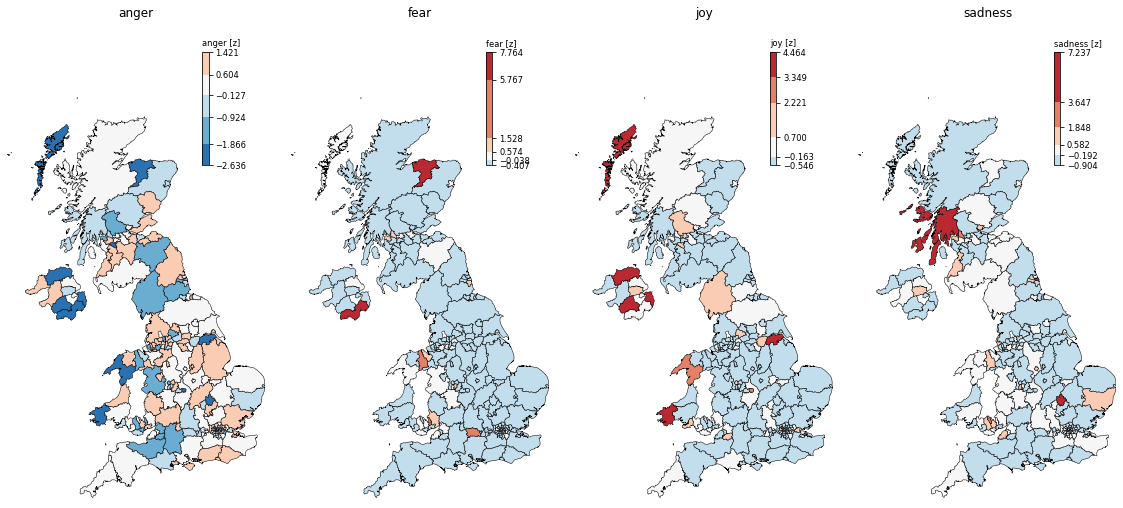

In [66]:
fig, axes = small_multiples_from_geodataframe(
    gdf, n_variables=len(labels), height=7, col_wrap=4, remove_axes=True
)

joint_gdf = gdf.join(place_sentiment.pipe(standardize_columns), on="shapeName")

for ax, col in zip(axes, place_sentiment.columns):
    choropleth_map(
        ax,
        joint_gdf,
        col,
        k=5,
        linewidth=0.5,
        edgecolor="black",
        binning="fisher_jenks",
        cbar_args=dict(
            label=f"{col} [z]",
            height="25%",
            width="3%",
            orientation="vertical",
            location="upper right",
            label_size="small",
            bbox_to_anchor=(0.0, 0.0, 0.8, 0.95),
        ),
    )

    ax.set_title(col)


fig.tight_layout()


/home/egraells/resources/aves/src/aves/features/geo.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ).pipe(lambda x: x[x.geometry.area > 0])


<AxesSubplot:>

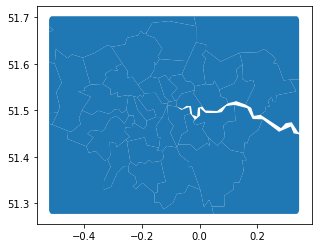

In [67]:
# https://woeplanet.org/id/23416974/
london_bbox = [-0.51035, 51.286839, 0.33403, 51.692322]
gdf_london = clip_area_geodataframe(gdf, london_bbox, buffer=0.01)
gdf_london.plot()


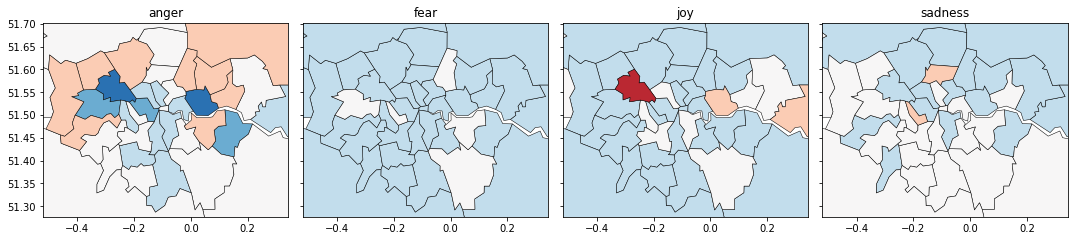

In [68]:
fig, axes = small_multiples_from_geodataframe(gdf_london, n_variables=len(labels), height=6, col_wrap=5, remove_axes=False)

joint_gdf = gdf.join(place_sentiment.pipe(standardize_columns), on='shapeName')

for ax, col in zip(axes, place_sentiment.columns):
    choropleth_map(
        ax,
        joint_gdf,
        col,
        k=5,
        linewidth=0.5,
        edgecolor="black",
        binning="fisher_jenks",
        legend=None
    )
    #joint_gdf.plot(ax=ax, column=col, aspect=None, cmap='RdBu')
    #gdf.plot(facecolor='none', edgecolor='black', linewidth=0.1, ax=ax, aspect=None)
    ax.set_title(col)


fig.tight_layout()

In [69]:
aspect_ratio = (london_bbox[2] - london_bbox[0]) / (london_bbox[3] - london_bbox[1])
aspect_ratio

2.0824054276011736

/tmp/ipykernel_3900/1904621091.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


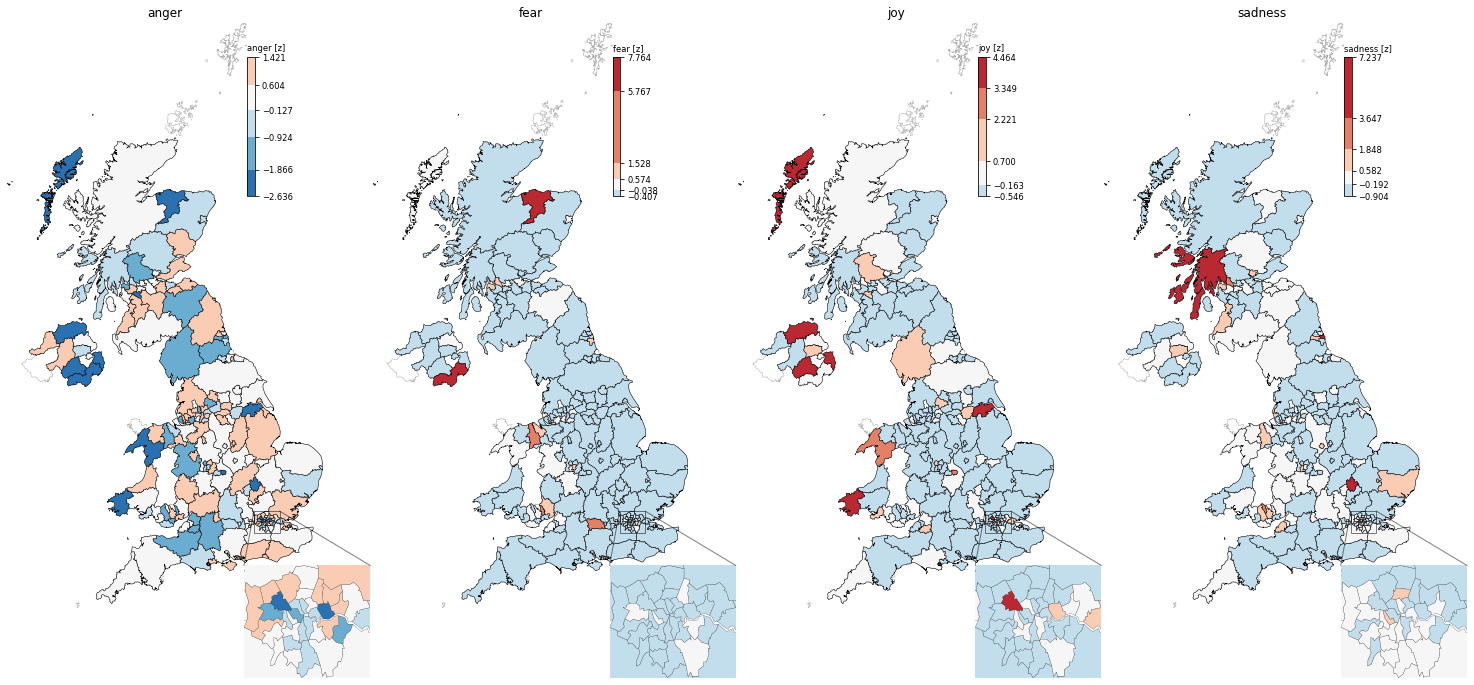

In [70]:
fig, axes = small_multiples_from_geodataframe(
    gdf, n_variables=4, height=9, col_wrap=4, remove_axes=True
)

joint_gdf = gdf.join(place_sentiment.pipe(standardize_columns), on="shapeName")

for ax, col in zip(axes, place_sentiment.columns):
    gdf.plot(facecolor='none', edgecolor='#abacab', linewidth=0.5, ax=ax, aspect=None)
    
    choropleth_map(
        ax,
        joint_gdf,
        col,
        k=5,
        linewidth=0.5,
        edgecolor="black",
        binning="fisher_jenks",
        cbar_args=dict(
            label=f"{col} [z]",
            height="25%",
            width="3%",
            orientation="vertical",
            location="upper right",
            label_size="small",
            bbox_to_anchor=(0.0, 0.0, 0.8, 0.95),
        ),
    )
    # joint_gdf.plot(ax=ax, column=col, aspect=None, cmap='RdBu')
    
    ax.set_title(col)

    axins = ax.inset_axes([0.75, -0.12, 0.4, 0.4 / aspect_ratio])
    axins.set_axis_off()
    #axins.imshow(Z2, extent=extent, origin="lower")
    # sub region of the original image
    #x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
    axins.set_xlim(london_bbox[0], london_bbox[2])
    axins.set_ylim(london_bbox[1], london_bbox[3])
    #axins.set_xticklabels([])
    #axins.set_yticklabels([])

    choropleth_map(
        axins,
        joint_gdf,
        col,
        k=5,
        linewidth=0.2,
        edgecolor="black",
        binning="fisher_jenks",
        legend=None
    )

    ax.indicate_inset_zoom(axins, edgecolor="black", zorder=50)


fig.tight_layout()

This is an example to quickly inspect evolution of sentiment:

<AxesSubplot:xlabel='created_at'>

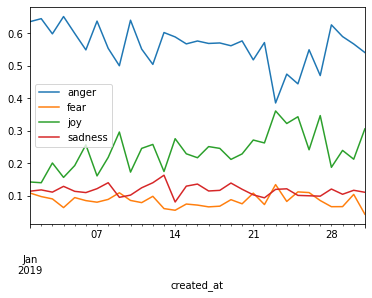

In [78]:
# Note the order: if you join tweets with tweet_emotions, the result will be a GeoDataFrame. that modifies the plot function.
# Instead, we are interested in a DataFrame.

tweet_emotions.join(tweets).resample("1d", on="created_at")[
    tweet_emotions.columns
].mean().plot()


### Correlating Emotion and Narratives

We may want to characterize the topics underpinning the discussion. For instance, we cannot say with confidence that a topic characterized by a high association to a negative word is negative, because we don't know the context of the negative word. However, the sentiment characterization does that. 

Since we have estimated these measures for the same unit of analysis, one step toward characterizing topics is through correlation.

In [79]:
nmf_topic_x_emotion = (
    place_sentiment.join(nmf_place_topic)
    .fillna(0)
    .corr()
    .loc[nmf_place_topic.columns, place_sentiment.columns]
    .set_index(nmf_topic_labels.map(lambda x: x.replace("\n", ",")))
)

lda_topic_x_emotion = (
    place_sentiment.join(lda_place_topic)
    .fillna(0)
    .corr()
    .loc[lda_place_topic.columns, place_sentiment.columns]
    .set_index(lda_topic_labels.map(lambda x: x.replace("\n", ",")))
)


/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 127988 (\N{WAVING BLACK FLAG}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 917607 (\N{TAG LATIN SMALL LETTER G}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 917602 (\N{TAG LATIN SMALL LETTER B}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 917619 (\N{TAG LATIN SMALL LETTER S}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 917603 (\N{TAG LATIN SMALL LETTER C}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/li

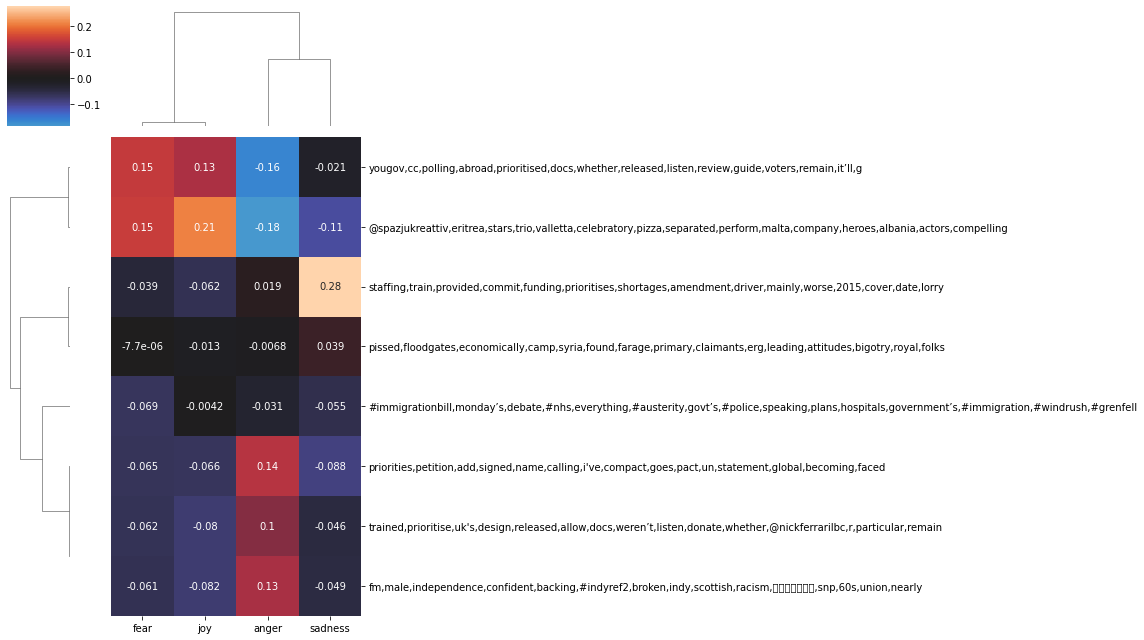

In [80]:
g = sns.clustermap(nmf_topic_x_emotion, center=0, figsize=(16, 9), annot=True, metric='cosine')
g.fig.tight_layout()

/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.draw()
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/seaborn/matrix.py:1203: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  self._figure.tight_layout(**tight_params)
/home/egraells/miniconda3/envs/tsundoku/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


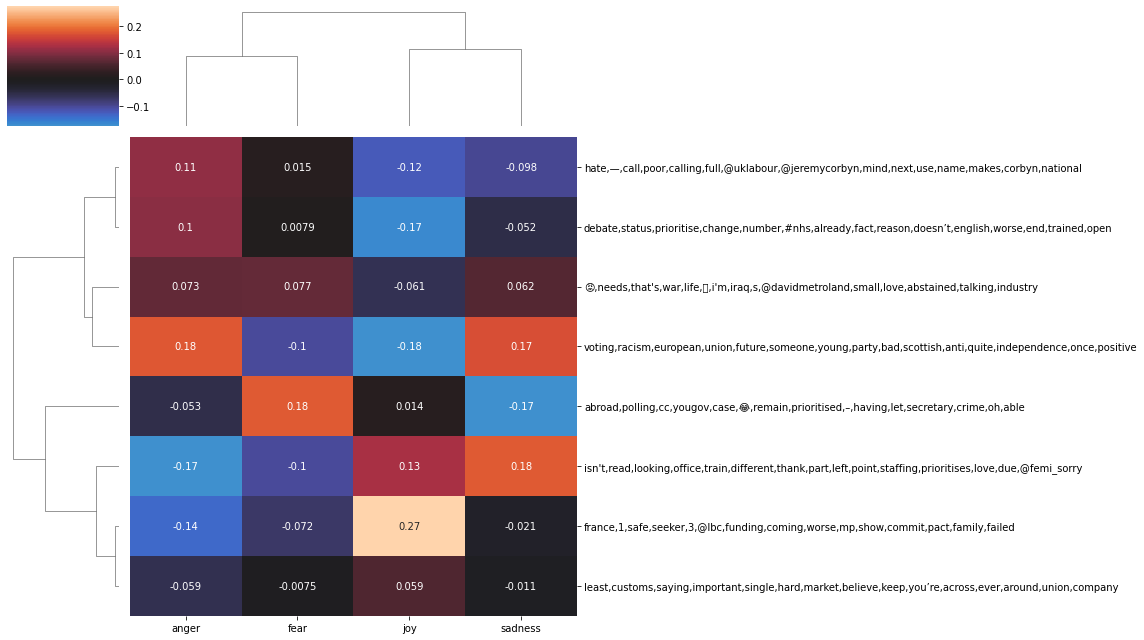

In [81]:
g = sns.clustermap(lda_topic_x_emotion, center=0, figsize=(16, 9), annot=True, metric='cosine')
g.fig.tight_layout()

Which one to pick? It seems that the results are not _that_ different. 

This is not the end of the study. We should do a careful qualitative analysis that can be supported by these numbers.


## Remaining Questions

### How to select a topic model?

My advice would be to test if simpler models give you reasonable results. If so, before moving to a more complex model, see if you can improve your data or your pre-processing. I like NMF for its simplicity and speed. And results are usually good enough. As with LDA, you can find evidence regarding its usefulness, thus, it is not a choice hard to justify.

Note that there are multiple versions of NMF and LDA. The [gensim](https://radimrehurek.com/gensim/) library is a good starting point as it has many implementations of those variants, as well as of other models.

### How to select the number of topics?

Do not focus only on quantitative measurements. Think about your assumptions of the data. Keep in mind typical evaluations (such as selecting a model based on Log-Likelihood or similar), but remember that those metrics are not necessarily related to your needs or assumptions about the data and the phenomena under study.

For instance, NMF tries to reconstruct the original matrix. As such, the "goodness of fit" is measured through matrix reconstruction error. You will notice that, as you increase the rank of the latent matrices, the fit improves always. 

Note that topics are _latent_, sometimes they do not have a human interpretation. A way to surpass this and have more interpretable topics is to use semi-supervised models. One of them is [Corex Topic Model](https://github.com/gregversteeg/corex_topic). where you can anchor words to topics as a way to guide the inference.

Always visualize what you do :) It will help you to pinpoint potential insights and also potential errors.

### Which transformer model to use?

I would say that every week there is a new model! The field is growing in a quite spectacular way, what I suggest is to find model authors that you trust and that have evaluated the new models in datasets similar to yours. For instance, here we used [tweeteval](https://github.com/cardiffnlp/tweeteval), which is trained and fine-tuned with tweets.

## Thanks!